In [24]:
import pandas as pd
from operator import itemgetter
import ast

import matplotlib.pyplot as plt

import networkx as nx
import networkx.algorithms.community as nx_comm

In [25]:
# Baca file csv
df = pd.read_csv("tweets-04-07.csv", index_col = [0])

In [26]:
df.head()

,author_id,context_annotations,created_at,entities,id,in_reply_to_user_id,text,name,username
0,911714193828610048,"[{'domain': {'id': '65', 'name': 'Interests an...",2022-07-03 19:01:38+00:00,"{'urls': [{'start': 30, 'end': 53, 'url': 'htt...",1543671325889380354,NaN,RT @Azorukonn: Meditating uwu https://t.co/sOw...,🎐Azo☁️,Azorukonn
1,978882263780937728,"[{'domain': {'id': '65', 'name': 'Interests an...",2022-07-03 19:01:24+00:00,"{'mentions': [{'start': 0, 'end': 15, 'usernam...",1543671264694308864,9.788823e+17,@ohmybeautybank penting bgt buat nata lagi soa...,"Cherry up, Ki bok! 🍒",timtempe
2,978882263780937728,"[{'domain': {'id': '65', 'name': 'Interests an...",2022-07-03 18:56:54+00:00,"{'mentions': [{'start': 0, 'end': 15, 'usernam...",1543670132236464129,9.948013e+17,@ohmybeautybank Kalau buat ngatasin udah banya...,"Cherry up, Ki bok! 🍒",timtempe
3,781615938583924736,"[{'domain': {'id': '45', 'name': 'Brand Vertic...",2022-07-03 19:01:21+00:00,"{'urls': [{'start': 30, 'end': 53, 'url': 'htt...",1543671253512364036,NaN,RT @ryosuketarou: USJ×JUJUTSU https://t.co/W01...,lin,eraeshkigal
4,2603170970,"[{'domain': {'id': '46', 'name': 'Brand Catego...",2022-07-03 19:01:10+00:00,"{'urls': [{'start': 130, 'end': 153, 'url': 'h...",1543671205642833922,NaN,[ TikTok #dystonia ]\n\n#duet with @\dr.jmack ...,dystobot,dystobot


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9916 entries, 0 to 9915
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   author_id            9916 non-null   int64  
 1   context_annotations  9916 non-null   object 
 2   created_at           9916 non-null   object 
 3   entities             9230 non-null   object 
 4   id                   9916 non-null   int64  
 5   in_reply_to_user_id  2347 non-null   float64
 6   text                 9916 non-null   object 
 7   name                 9914 non-null   object 
 8   username             9916 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 774.7+ KB


# Preprocessing

**Field yang akan di pakai:**
- author_id
- entities (untuk mencari username mention)
- in_reply_to_user_id (dikarenakan pada field ini hanya berupa id tanpa memiliki username, jadi kita gunakan atribut author_id sebagai referensi untuk mendapatkan username-nya)
- username

## Mengambil kolom in_reply_to_user_id untuk dijadikan target node reply

In [28]:
in_reply_to_user_df = df[df['in_reply_to_user_id'].notna()]
in_reply_to_user_df.head()

,author_id,context_annotations,created_at,entities,id,in_reply_to_user_id,text,name,username
1,978882263780937728,"[{'domain': {'id': '65', 'name': 'Interests an...",2022-07-03 19:01:24+00:00,"{'mentions': [{'start': 0, 'end': 15, 'usernam...",1543671264694308864,9.788823e+17,@ohmybeautybank penting bgt buat nata lagi soa...,"Cherry up, Ki bok! 🍒",timtempe
2,978882263780937728,"[{'domain': {'id': '65', 'name': 'Interests an...",2022-07-03 18:56:54+00:00,"{'mentions': [{'start': 0, 'end': 15, 'usernam...",1543670132236464129,9.948013e+17,@ohmybeautybank Kalau buat ngatasin udah banya...,"Cherry up, Ki bok! 🍒",timtempe
6,1320074687255228416,"[{'domain': {'id': '65', 'name': 'Interests an...",2022-07-03 19:01:01+00:00,"{'mentions': [{'start': 0, 'end': 15, 'usernam...",1543671171064872960,9.948013e+17,@ohmybeautybank parfum miniso yang de garden o...,kangcendol,abyprtmaa
8,2501435702,"[{'domain': {'id': '65', 'name': 'Interests an...",2022-07-03 19:01:01+00:00,"{'urls': [{'start': 63, 'end': 86, 'url': 'htt...",1543671168154357761,7.894107e+17,@rlgxg pake totebag pantone kyk gini. nama tok...,pibi.,dancqer
14,1245295684971950081,"[{'domain': {'id': '65', 'name': 'Interests an...",2022-07-03 19:00:11+00:00,"{'urls': [{'start': 301, 'end': 324, 'url': 'h...",1543670961320239105,1.245296e+18,@ohmybeautybank 6. Coba aplikasiin foundie &am...,Starlight💫,Polaris_0404


### Mengubah nama kolom username menjadi source dan kolom username yang me-reply menjadi target

In [29]:
in_reply_to_user_df = in_reply_to_user_df.merge(df, left_on='in_reply_to_user_id', right_on='author_id')
in_reply_to_user_df = in_reply_to_user_df.rename(columns={"username_x": "target","username_y": "username", "text_x": "text"})
in_reply_to_user_df = in_reply_to_user_df[["username", "target", "text"]]
in_reply_to_user_df = in_reply_to_user_df.drop_duplicates(keep= 'first', ignore_index=True)

In [30]:
in_reply_to_user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488 entries, 0 to 487
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   username  488 non-null    object
 1   target    488 non-null    object
 2   text      488 non-null    object
dtypes: object(3)
memory usage: 11.6+ KB


In [31]:
in_reply_to_user_df.head()

,username,target,text
0,ohmybeautybank,timtempe,@ohmybeautybank Kalau buat ngatasin udah banya...
1,ohmybeautybank,abyprtmaa,@ohmybeautybank parfum miniso yang de garden o...
2,ohmybeautybank,Polaris_0404,@ohmybeautybank 1. Cari foundie yg transfer pr...
3,ohmybeautybank,bubblegun__,@ohmybeautybank Ini nder punya aku ga sampe 20...
4,ohmybeautybank,clapclapcacaca1,@ohmybeautybank kalo aku pake skincare dermies...


## Mengambil mentions dari kolom entities untuk dijadikan target node mention

In [32]:
mentions = []
for i in range(len(df)):
  if isinstance((df["entities"][i]), str):
    if "mentions" in ast.literal_eval(df["entities"][i]).keys():
      mention = {
          "id": df["id"][i],
          "mention_username": ast.literal_eval(df["entities"][i]).get("mentions")[0].get("username")
        }
      mentions.append(mention)

mentions_df = pd.DataFrame(mentions)
mentions_df.head()

,id,mention_username
0,1543671325889380354,Azorukonn
1,1543671264694308864,ohmybeautybank
2,1543670132236464129,ohmybeautybank
3,1543671253512364036,ryosuketarou
4,1543671171064872960,ohmybeautybank


In [33]:
tweets_mention_df = mentions_df.merge(df, left_on='id', right_on='id')
tweets_mention_df.head()

,id,mention_username,author_id,context_annotations,created_at,entities,in_reply_to_user_id,text,name,username
0,1543671325889380354,Azorukonn,911714193828610048,"[{'domain': {'id': '65', 'name': 'Interests an...",2022-07-03 19:01:38+00:00,"{'urls': [{'start': 30, 'end': 53, 'url': 'htt...",NaN,RT @Azorukonn: Meditating uwu https://t.co/sOw...,🎐Azo☁️,Azorukonn
1,1543671264694308864,ohmybeautybank,978882263780937728,"[{'domain': {'id': '65', 'name': 'Interests an...",2022-07-03 19:01:24+00:00,"{'mentions': [{'start': 0, 'end': 15, 'usernam...",9.788823e+17,@ohmybeautybank penting bgt buat nata lagi soa...,"Cherry up, Ki bok! 🍒",timtempe
2,1543670132236464129,ohmybeautybank,978882263780937728,"[{'domain': {'id': '65', 'name': 'Interests an...",2022-07-03 18:56:54+00:00,"{'mentions': [{'start': 0, 'end': 15, 'usernam...",9.948013e+17,@ohmybeautybank Kalau buat ngatasin udah banya...,"Cherry up, Ki bok! 🍒",timtempe
3,1543671253512364036,ryosuketarou,781615938583924736,"[{'domain': {'id': '45', 'name': 'Brand Vertic...",2022-07-03 19:01:21+00:00,"{'urls': [{'start': 30, 'end': 53, 'url': 'htt...",NaN,RT @ryosuketarou: USJ×JUJUTSU https://t.co/W01...,lin,eraeshkigal
4,1543671171064872960,ohmybeautybank,1320074687255228416,"[{'domain': {'id': '65', 'name': 'Interests an...",2022-07-03 19:01:01+00:00,"{'mentions': [{'start': 0, 'end': 15, 'usernam...",9.948013e+17,@ohmybeautybank parfum miniso yang de garden o...,kangcendol,abyprtmaa


In [34]:
user_mentions_df = tweets_mention_df.rename(columns={"username": "username", "mention_username": "target"})
user_mentions_df = user_mentions_df[["username", "target", "text"]]
user_mentions_df = user_mentions_df.drop_duplicates(keep= 'first', ignore_index=True)
user_mentions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7173 entries, 0 to 7172
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   username  7173 non-null   object
 1   target    7173 non-null   object
 2   text      7173 non-null   object
dtypes: object(3)
memory usage: 168.2+ KB


In [35]:
user_mentions_df.head()

,username,target,text
0,Azorukonn,Azorukonn,RT @Azorukonn: Meditating uwu https://t.co/sOw...
1,timtempe,ohmybeautybank,@ohmybeautybank penting bgt buat nata lagi soa...
2,timtempe,ohmybeautybank,@ohmybeautybank Kalau buat ngatasin udah banya...
3,eraeshkigal,ryosuketarou,RT @ryosuketarou: USJ×JUJUTSU https://t.co/W01...
4,abyprtmaa,ohmybeautybank,@ohmybeautybank parfum miniso yang de garden o...


In [36]:
final_df = pd.concat([in_reply_to_user_df, user_mentions_df], ignore_index=True)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7661 entries, 0 to 7660
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   username  7661 non-null   object
 1   target    7661 non-null   object
 2   text      7661 non-null   object
dtypes: object(3)
memory usage: 179.7+ KB


In [37]:
final_df.head()

,username,target,text
0,ohmybeautybank,timtempe,@ohmybeautybank Kalau buat ngatasin udah banya...
1,ohmybeautybank,abyprtmaa,@ohmybeautybank parfum miniso yang de garden o...
2,ohmybeautybank,Polaris_0404,@ohmybeautybank 1. Cari foundie yg transfer pr...
3,ohmybeautybank,bubblegun__,@ohmybeautybank Ini nder punya aku ga sampe 20...
4,ohmybeautybank,clapclapcacaca1,@ohmybeautybank kalo aku pake skincare dermies...


# Proses Pembentukan Jejaring Sosial

In [38]:
G = nx.Graph()

In [39]:
# Pemilihan atribut yang akan digunakan
G = nx.from_pandas_edgelist(final_df, 'username', 'target')

In [40]:
pos = nx.kamada_kawai_layout(G)

## Mengukur Topologi Jejaring Sosial Secara Keseluruhan

In [41]:
# Menampilkan Jumlah Nodes
print('Jumlah nodes', nx.number_of_nodes(G))

# Menampilkan Jumlah Edges
print('Jumlah edges', nx.number_of_edges(G))

# Menampilkan Density
print('Density', nx.density(G))

# Menapilkan Jumlah Connected Component
print('Jumlah connected component', nx.number_connected_components(G))

Jumlah nodes 7206
Jumlah edges 6541
Density 0.00025196829768084003
Jumlah connected component 1032


In [42]:
# Deteksi komunitas menggunakan algoritma louvain
communities = sorted(nx_comm.louvain_communities(G), key=len, reverse=True)
nx_comm.modularity(G, communities)

0.9167269822579946

In [43]:
len(communities)

1039

In [44]:
modularity_dict = {} # Create a blank dictionary
for i,c in enumerate(communities): # Loop through the list of communities, keeping track of the number for the community
    for name in c: # Loop through each person in a community
        modularity_dict[name] = i # Create an entry in the dictionary for the person, where the value is which group they belong to.

# Now you can add modularity information like we did the other metrics
nx.set_node_attributes(G, modularity_dict, 'modularity')

# Visualisasi

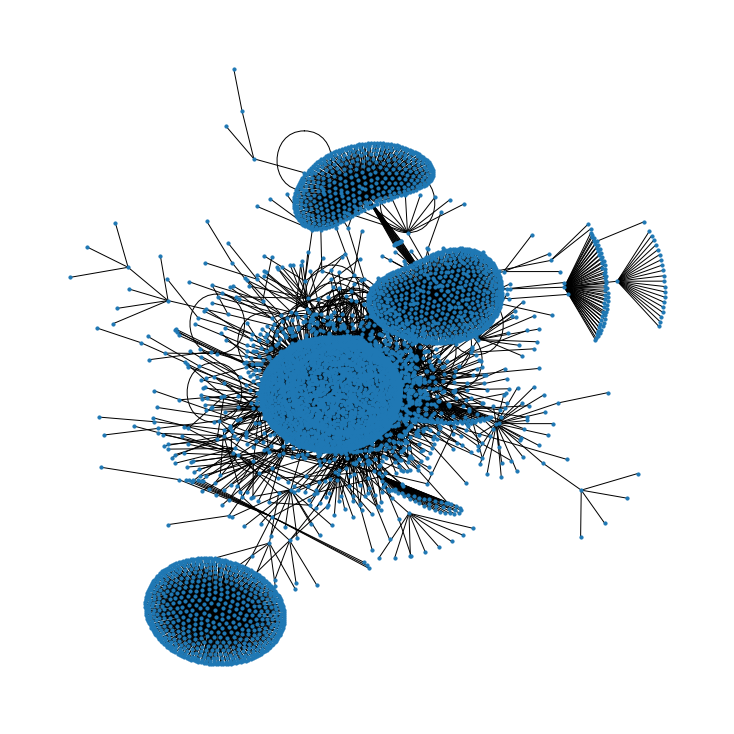

In [45]:
# Memvisualisasikan jaringan
plt.figure(figsize=(10,10))
nx.draw(G, with_labels=False,
        node_size=10,
        cmap=plt.get_cmap('jet'),
        pos=pos)

## Visualisasi Segmen

In [46]:
# Membuat fungsi komunitas
def set_node_community(G, communities):
    "'Add community to node attributes'"
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['group'] = c + 1

# Membuat fungsi warna
def get_color(i, r_off=1, g_off=1, b_off=1):
    "'Assign a color to an edge'"
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i+r_off)*3) % n)/(n-1)
    g=low+span*(((i+g_off)*5)%n)/(n-1)
    b=low+span*(((i+b_off)*7)%n)/(n-1)
    return(r,g,b)

# Menetapkan komunitas untuk setiap node
community = set_node_community(G, communities)

# Menetapkan warna node
node_color = [get_color(G.nodes[v]['group']) for v in G.nodes]

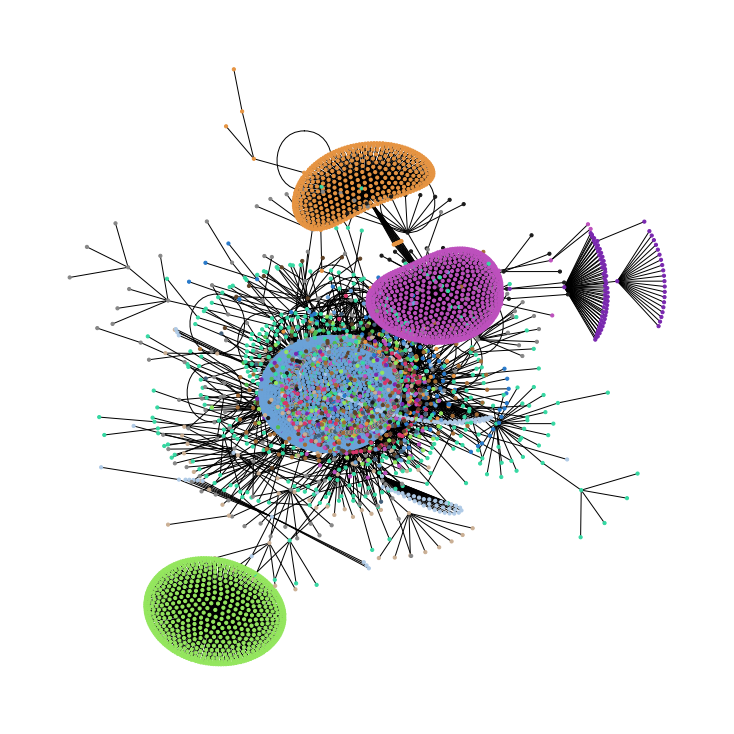

In [47]:
# Memvisualisasikan jaringan
plt.figure(figsize=(10,10))
nx.draw(G, with_labels=False,
        node_color=node_color,
        node_size=10,
        cmap=plt.get_cmap('jet'),
        pos=pos)